# Netflix-IMDb Machine Learning Final Project
## Alyx Cleveland and Tony Barrows

Let's first download and gather our data for review.

In [48]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats

from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

random_state = 42

plt.rcParams.update({'font.size':13})

This is a very large data set, so let's dispense with it as quickly as we can. We need to download the *names* data set in order to get the primary key, merge on the *ratings* data set, and finally merge that again with the *netflix* data set.

In [49]:
def load_data_live():
    ''' Load Netflix data set from disk. Load IMDb data sets from IMDb website. Merge on title, write merged
    version to disk.'''
    nflix = pd.read_csv("../data/netflix_titles.csv")
    imdb_names = pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", compression='gzip', delimiter = "\t",
                            low_memory = False)
    imdb_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", compression = 'gzip', delimiter = "\t",
                              low_memory = False)

    # just need the unique id 'tconst'
    imdb_names = imdb_names[['tconst', 'originalTitle']]
    imdb = imdb_ratings.merge(imdb_names, how = 'left', on = 'tconst')

    nflix = nflix.merge(imdb, how = 'left', left_on = 'title', right_on = 'originalTitle')
    nflix.to_csv("../data/nflix_merged.csv")
    
    return nflix

# only pull from by API if not on disk
try:
    nflix = pd.read_csv("../data/nflix_merged.csv")
except:
    nflix = load_data_live()

In [50]:
nflix

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,tconst,averageRating,numVotes,originalTitle
0,0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,tt2096351,7.8,2053.0,3%
1,1,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,tt4922804,7.4,21771.0,3%
2,2,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,tt5979312,6.0,567.0,7:19
3,3,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",tt2100376,4.6,849.0,23:59
4,4,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",tt0191312,6.0,73.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22408,22408,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,tt3776484,6.1,389.0,Zubaan
22409,22409,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,tt7368392,7.3,10.0,Zubaan
22410,22410,s7785,Movie,Zulu Man in Japan,NaN,Nasty C,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast...",NaN,NaN,NaN,NaN
22411,22411,s7786,TV Show,Zumbo's Just Desserts,NaN,"Adriano Zumbo, Rachel Khoo",Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...,tt7239256,6.9,1864.0,Zumbo's Just Desserts


In [51]:
nflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22413 entries, 0 to 22412
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     22413 non-null  int64  
 1   show_id        22413 non-null  object 
 2   type           22413 non-null  object 
 3   title          22413 non-null  object 
 4   director       15336 non-null  object 
 5   cast           20796 non-null  object 
 6   country        21150 non-null  object 
 7   date_added     22356 non-null  object 
 8   release_year   22413 non-null  int64  
 9   rating         22406 non-null  object 
 10  duration       22413 non-null  object 
 11  listed_in      22413 non-null  object 
 12  description    22413 non-null  object 
 13  tconst         20304 non-null  object 
 14  averageRating  20304 non-null  float64
 15  numVotes       20304 non-null  float64
 16  originalTitle  20304 non-null  object 
dtypes: float64(2), int64(2), object(13)
memory usage: 

_______

TODO:
* Weight ratings by number of votes (or use as separate targets: i.e., num votes is measure of popularity)
    - Might be a relationship between number of votes and ratings

* Make a binned version of IMDb ratings for classification methods
* Text pre-processing
* Feature selection
    - e.g., Ridge Regression or LASSO selection
* Algorithm definition
    - Write algorithms in pseducode (in LaTeX) -- likely forest methods
    - MSE or RMSE to describe bias-variance tradeoff 
    - Plot these.

*******

### Descriptives

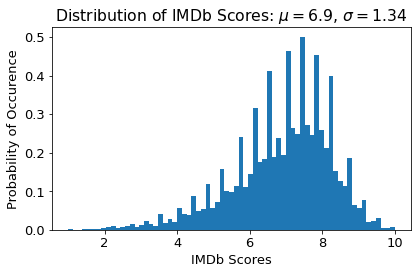

In [52]:
avg = np.mean(nflix['averageRating'])
sd = np.std(nflix['averageRating'])
title = 'Distribution of IMDb Scores: $\mu=$' + str(round(avg, 2)) + ', $\sigma=$' + str(round(sd, 2))

plt.hist(nflix['averageRating'], density = True, bins = 'auto')
plt.xlabel('IMDb Scores')
plt.ylabel('Probability of Occurence')
plt.title(title)

plt.tight_layout()
# plt.savefig('../out/imdb_histogram.png', dpi=600)
plt.show()

********

## Reshaping/Preprocessing

We want to change the structure of the data to substantially reduce the complexity of the input features. Let's first separate things into structures that make sense. This is mainly a text processing problem.

Split 'title' and 'description' by every space:

In [53]:
# make a copy
nflix_sub = nflix.copy()
nflix_sub['title'] = nflix_sub['title'].str.split(' ')
nflix_sub['title']

0                                                    [3%]
1                                                    [3%]
2                                                  [7:19]
3                                                 [23:59]
4                                                     [9]
                               ...                       
22408                                            [Zubaan]
22409                                            [Zubaan]
22410                              [Zulu, Man, in, Japan]
22411                           [Zumbo's, Just, Desserts]
22412    [ZZ, TOP:, THAT, LITTLE, OL', BAND, FROM, TEXAS]
Name: title, Length: 22413, dtype: object

We also want to remove unnecessary conjoining (i.e. 'stop') words and punctuation from the description in order to reduce its size and maximize its feature importance:

In [54]:
stop = text.ENGLISH_STOP_WORDS

# coerce to lowercase to match stop words
nflix_sub['description'] = nflix_sub['description'].str.lower()
nflix_sub['description'] = nflix_sub['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
nflix_sub['description'] = nflix_sub['description'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
nflix_sub['description']

0        future elite inhabit island paradise far crowd...
1        future elite inhabit island paradise far crowd...
2        devastating earthquake hits mexico trapped sur...
3        army recruit fellow soldiers forced confront t...
4        postapocalyptic robots hide fear dangerous mac...
                               ...                        
22408    scrappy poor boy worms way dysfunctional facin...
22409    scrappy poor boy worms way dysfunctional facin...
22410    south african rapper nasty c hits stage street...
22411    dessert wizard adriano zumbo looks tense compe...
22412    documentary delves mystique trio explores enig...
Name: description, Length: 22413, dtype: object

In [55]:
nflix_sub['description'] = nflix_sub['description'].str.split(' ')
nflix_sub['description']

0        [future, elite, inhabit, island, paradise, far...
1        [future, elite, inhabit, island, paradise, far...
2        [devastating, earthquake, hits, mexico, trappe...
3        [army, recruit, fellow, soldiers, forced, conf...
4        [postapocalyptic, robots, hide, fear, dangerou...
                               ...                        
22408    [scrappy, poor, boy, worms, way, dysfunctional...
22409    [scrappy, poor, boy, worms, way, dysfunctional...
22410    [south, african, rapper, nasty, c, hits, stage...
22411    [dessert, wizard, adriano, zumbo, looks, tense...
22412    [documentary, delves, mystique, trio, explores...
Name: description, Length: 22413, dtype: object

Split cast on commas:

In [56]:
nflix_sub['cast'] = nflix_sub['cast'].str.split(',')
nflix_sub['cast']

0        [João Miguel,  Bianca Comparato,  Michel Gomes...
1        [João Miguel,  Bianca Comparato,  Michel Gomes...
2        [Demián Bichir,  Héctor Bonilla,  Oscar Serran...
3        [Tedd Chan,  Stella Chung,  Henley Hii,  Lawre...
4        [Elijah Wood,  John C. Reilly,  Jennifer Conne...
                               ...                        
22408    [Vicky Kaushal,  Sarah-Jane Dias,  Raaghav Cha...
22409    [Vicky Kaushal,  Sarah-Jane Dias,  Raaghav Cha...
22410                                            [Nasty C]
22411                        [Adriano Zumbo,  Rachel Khoo]
22412                                                  NaN
Name: cast, Length: 22413, dtype: object

Now, entries which were large text strings are now represented as lists of much smaller strings.

In [57]:
nflix_sub = nflix_sub[['title', 'director', 'cast', 'country', 'date_added', 'rating',
           'release_year', 'duration', 'description','averageRating', 'numVotes']]
nflix_sub.to_csv('../data/nflix_sub.csv')

### Frequency of unique terms

In [58]:
def count_unique(col):
    col = col.dropna()
    return len(set(itertools.chain.from_iterable(col)))

list_features = ['title', 'cast', 'description']

for f in list_features:
    print(f, ": ", str(count_unique(nflix_sub[f])))

title :  9384
cast :  35372
description :  15420


In [59]:
# above method doesn't work on single entries
single_features = ['director', 'duration', 'country', 'rating']

for f in single_features:
    print(f, ":", len(set(nflix_sub[f].dropna())))

director : 4049
duration : 216
country : 681
rating : 14


*******

## Feature Engineering and Algorithms

Update: taking a different approach to feature extraction.

### Detect missingness

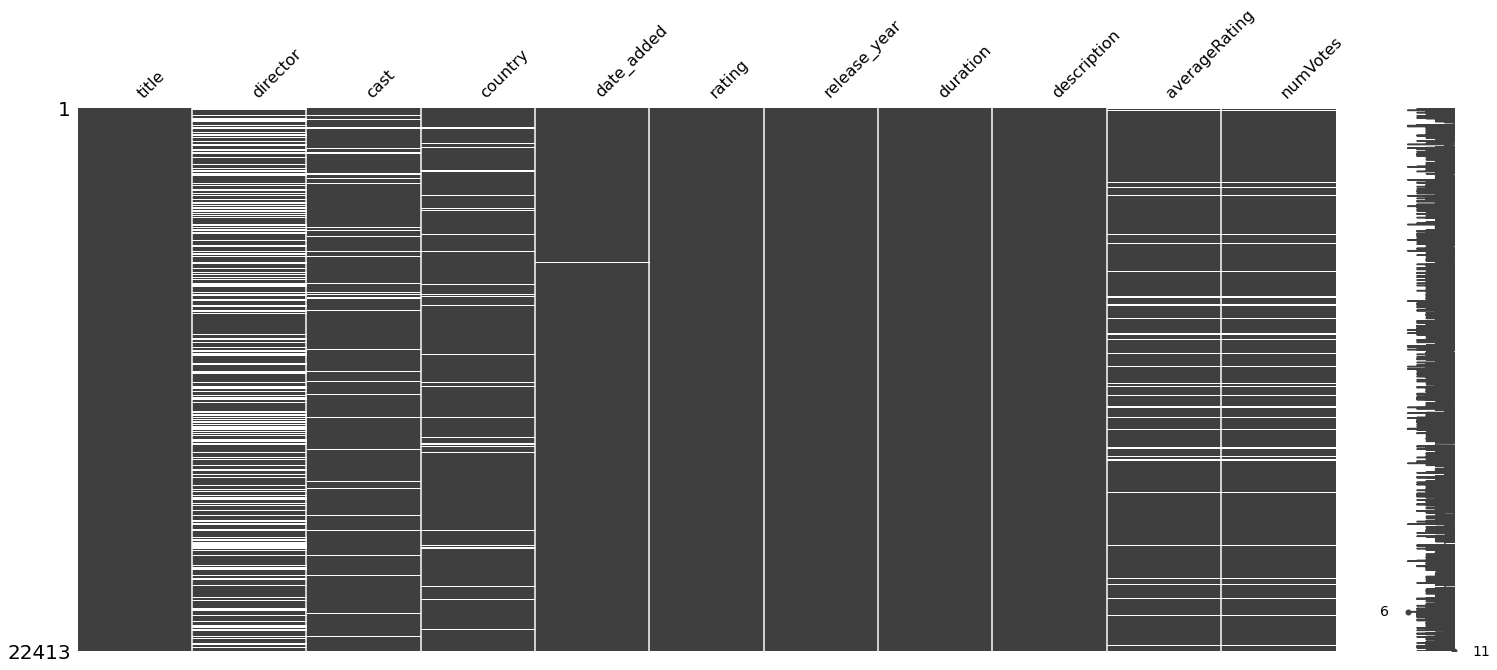

In [60]:
# create susbset of useful columns
nflix_sub = nflix[['title', 'director', 'cast', 'country', 'date_added', 'rating',
           'release_year', 'duration', 'description','averageRating', 'numVotes']]

# drop entries without response variable
nflix = nflix[nflix['averageRating'].isna() == False]

# nifty little missing data visualizer: https://github.com/ResidentMario/missingno.git
msno.matrix(nflix_sub)
# plt.savefig('../out/merged_missing.png', dpi=300, bbox_inches='tight')
plt.show()

The amount of missingness in the `director` column might make it a poor candidate to use in prediction.

In [61]:
def sepdata(nonan_imp):
    '''separates numerical and categorical variables into subsets
    quant and qual'''    
    for name in nonan_imp.columns:
        if type(nonan_imp[name][1]) == str:
            nonan_imp[name] = nonan_imp[name].astype(str)
        elif type(nonan_imp[name][1]) == int:
            #print(name)
            nonan_imp[name] = nonan_imp[name].astype(int)
        else:
            #nonan_imp[name] = pd.to_numeric(nonan_imp[name])
            nonan_imp[name] = nonan_imp[name].astype(str)

    quant = nonan_imp.select_dtypes(['number', 'float', 'int'])
    qual = nonan_imp.select_dtypes(['object'])
    
    return quant, qual

def prep():
    ''' produces a clean dataframe of X predictors and the y response 
    also encodes categorical variables'''
    fulldf = X
    ''' cut needs to be value between 0 and 1'''
    #nonan = dropcolna(fulldf, cut*len(fulldf))
    #nonan_imp = impute(nonan, 'most_frequent') #can use median here    
    quant, qual = sepdata(X)    
    #nona_enc = nonan_imp
    X_enc = X

    '''
    encoding catergorical variables
    '''    
    le = LabelEncoder()
    X_enc[qual.columns] = X_enc[qual.columns].apply(lambda
                col:le.fit_transform(col))     
    return X

def dropcolna(nonan):
    ''' takes full dataframe and drops columns with more missingness
    than the number, num, established by the cutoff later'''
    
    for feat in nonan.columns:
        if nonan[feat].isna().sum() > len(nonan):
            nonan.drop([feat], axis=1, inplace=True)
        else:
            '''sanity check for remaining nan'''
            print(feat, nonan[feat].isna().sum())
            pass
    print('new shape:', nonan.shape)
    return nonan

def impute(nonan):
    ''' imputes missing data by specified strategy, used 
    most frequent in this project'''
    values = nonan.values

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')    
    transformed_X = imp.fit_transform(X)    
    nonan_imp = pd.DataFrame(transformed_X, 
                             columns = [item for item in nonan.columns])
    ''' sanity check to make sure there is no missingness left'''    
    print(nonan_imp)    
    for feat in nonan_imp:
        print('Here!', feat, nonan_imp[feat].isna().sum())
    return nonan_imp 

### Encoding Data

In [62]:
df = nflix_sub
df = df.drop(['director'], axis=1)
df = df.dropna()
# df_sub = df.sample(frac=0.1, random_state=random_state)


y = df['averageRating']
X = df.drop(columns=['averageRating'])



In [63]:
# split into train and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

# vectorize training and testing features (separately)

def vectorize_data(X_train, X_test):
    '''Takes corpus of feature words and returns sparse tf-idf-vectorized matrix.
    Handles test and training data with different methods.'''
    
    vectorizer = text.TfidfVectorizer(analyzer='word', stop_words='english', lowercase=True,
                                     max_features = 1000, use_idf=False, dtype=np.float64, ngram_range = (2,2))
    
    train_out = pd.DataFrame(vectorizer.fit_transform(X_train).todense())
    test_out = pd.DataFrame(vectorizer.transform(X_test).todense())
    
    return train_out, test_out

# desc_tr, desc_ts = vectorize_data(X_train['description'], X_test['description'])
cast_tr, cast_ts = vectorize_data(X_train['cast'], X_test['cast'])
# title_tr, title_ts = vectorize_data(X_train['title'], X_test['title'])

cast_tr.shape

(14447, 1000)

Feature space becomes much too large with any of these, including different permutations of parameters.

*************

## Plot Descriptives

In [64]:
df['date_added'] = pd.to_datetime(df['date_added'])
df['release_year'] = pd.to_numeric(df['release_year'])

In [65]:
# correlations
cor_list = []

cor_list.append(stats.pearsonr(pd.to_numeric(df['date_added']), df['averageRating']))
cor_list.append(stats.pearsonr(df['release_year'], df['averageRating']))
cor_list.append(stats.pearsonr(df['numVotes'], df['averageRating']))

cor_list

[(0.01922230133129719, 0.009788137042406485),
 (-0.03161118839084694, 2.1491999647284334e-05),
 (0.05552926237246275, 8.174683595765491e-14)]

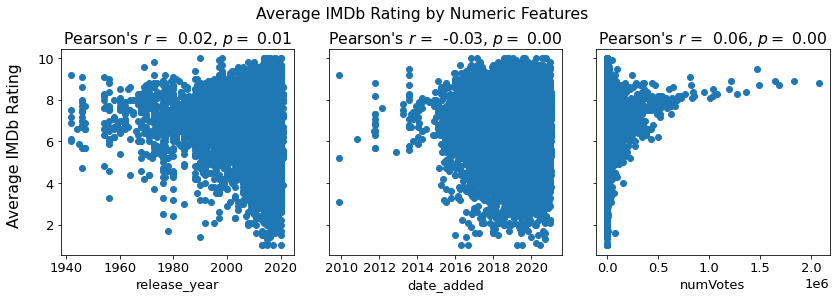

In [66]:
num_plts = ['release_year', 'date_added', 'numVotes']

nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows, ncols, sharey=True, figsize=(12,4))
fig.suptitle('Average IMDb Rating by Numeric Features')
fig.supylabel('Average IMDb Rating')
fig.tight_layout()
for i in range(len(num_plts)):
    axs[i].scatter(df[num_plts[i]], df['averageRating'])
    axs[i].set_xlabel(num_plts[i])
    
    pear_r = cor_list[i][0]
    p = cor_list[i][1]
    title = r"Pearson's $r$ =  {0:.{digits}f}, $p =$ {1:.{digits}f}".format(pear_r, p, digits=2)
    
    axs[i].set_title(title)
    
plt.savefig("../out/num_feature_dist.png", dpi=600, bbox_inches='tight')

**********

## Define Models

In [67]:
'''Helper function for cross validation'''
        
def split_folds(k):
    return KFold(n_splits=k, random_state=1, shuffle=True)

'''Models available'''

def lin_reg(X, y):
    ''' linear regression on all predictors'''
    model = {'name':'Linear',
             'mod_type':LinearRegression().fit(X,y),
             'color':'maroon'}
    return model

def lasso_reg(X, y, n):
    ''' lasso regression on all predictors'''
    model = {'name':'Lasso',
             'mod_type':LassoCV(cv = split_folds(n)).fit(X,y),
             'color':'royalblue'}
    return model

def ridge_reg(X, y, n):
    ''' ridge regression on all predictors'''
    model = {'name':'Ridge',
             'mod_type':RidgeCV(cv = split_folds(n)).fit(X,y),
             'color':'deepskyblue'}
    return model

def elastic_net(X, y, n):
    ''' elastic net regression on all predictors'''
    model = {'name':'Elastic Net',
             'mod_type':ElasticNetCV(cv = split_folds(n)).fit(X,y),
             'color':'indigo'}
    return model    

def kneighbors(X, y, search):
    ''' k-nearest neighbors model using boosted tree features
    (see run_models in oopmod.py)'''
    if search == True:
        param_grid = {'n_neighbors': [i for i in range(5,30)],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [i for i in range(20,40)],
              'p': [1, 2]}
        best_mod = GridSearchCV(KNeighborsRegressor(), param_grid=param_grid,
                                scoring='neg_mean_squared_error',cv=5,
                                verbose=True, pre_dispatch='2*n_jobs', n_jobs=-1)
        best_mod.fit(X,y)   
        mod = best_mod.best_estimator_
        print(best_mod.best_params_)
    else: 
        mod = KNeighborsRegressor(algorithm= 'auto', leaf_size= 20,
                                  n_neighbors= 28, p= 1, weights= 'distance')
    model = {'name':'KNN',
             'mod_type':mod.fit(X,y),
             'color':'orchid'}
    return model    
    
def tree_reg(X, y, search):
    ''' decision tree regression model'''
    if search == True:
        param_grid = {'criterion': ['mse', 'friedman_mse', 'mae'],
              'splitter': ['best', 'random'],
              'min_samples_split': [0.001, 0.01, 0.1, 0.15],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1]}
        best_mod = GridSearchCV(tree.DecisionTreeRegressor(),
                                param_grid=param_grid,
                                scoring='neg_mean_squared_error',cv=5,
                                verbose=True, pre_dispatch='2*n_jobs', n_jobs=-1)
        best_mod.fit(X,y)    
        print(best_mod.best_params_)
        mod = best_mod.best_estimator_
    else:
        mod = tree.DecisionTreeRegressor(criterion= 'mse', max_features= 'auto',
                                         min_impurity_decrease= 0.0,
                                         min_samples_split= 0.1,
                                         splitter= 'random')
    model = {'name':'Tree',
             'mod_type':mod.fit(X,y),
             'color':'olivedrab'}
    return model

def rand_for(X, y, search):
    ''' random forest model'''    
    if search == True:
        param_grid = {'n_estimators':[100],
                'criterion': ['mse', 'friedman_mse', 'mae'],
              'min_samples_split': [0.001, 0.01, 0.1, 0.15],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1]}
        best_mod = GridSearchCV(RandomForestRegressor(),
                                param_grid=param_grid,
                                scoring='neg_mean_squared_error',cv=5,
                                verbose=True, pre_dispatch='2*n_jobs', n_jobs=-1)
        best_mod.fit(X,y)    
        print(best_mod.best_params_)    
        mod = best_mod.best_estimator_
    else:
        mod = RandomForestRegressor(criterion= 'friedman_mse',
                                    max_features= 'auto',
                                    min_impurity_decrease= 0.01,
                                    min_samples_split= 0.001,
                                    n_estimators= 100)
    model = {'name':'Random Forest',
             'mod_type':mod.fit(X,y),
             'color':'limegreen'}
    return model

def boost_for(X, y, search):
    '''gradient boosted forest model '''        
    if search == True:
        param_grid = {
                'learning_rate': [0.05, 0.02, 0.1],
              'min_impurity_decrease': [0.001, 0.01, 0.1]}
        best_mod = GridSearchCV(GradientBoostingRegressor(),
                                param_grid=param_grid,
                                scoring='neg_mean_squared_error',cv=5,
                                verbose=True, pre_dispatch='2*n_jobs', n_jobs=-1)
        best_mod.fit(X,y)    
        print(best_mod.best_params_)    
        mod = best_mod.best_estimator_
    else:
        mod = GradientBoostingRegressor(learning_rate=0.05,
                                        min_impurity_decrease = 0.01)
    model = {'name':'Boosted Forest',
             'mod_type':mod.fit(X,y),
             'color':'forestgreen'}
    return model

def supp_vec_reg(X, y, search): 
    ''' support vector regression model using boosted tree features,
    see run_models in oopmod.py'''
    if search == True:
        param_grid = {'kernel': ['linear', 'rbf']}
        
        best_mod = GridSearchCV(SVR(), param_grid=param_grid,
                                scoring='neg_mean_squared_error',
                                cv=5, verbose=True, pre_dispatch='2*n_jobs',
                                n_jobs=-1)
        best_mod.fit(X,y)    
        print(best_mod.best_params_)
        mod = best_mod.best_estimator_
    else:
        mod = SVR(kernel = 'linear')
    
    model = {'name':'SVR',
             'mod_type':mod.fit(X,y),
             'color':'purple'}
    return model

def mlp(X, y, search):
    ''' multilayer perceptron model using boosted tree features,
    see run_models in oopmod.py'''    
    if search == True:
        param_grid = {'hidden_layer_sizes': [i for i in range(1,15)],
                      'activation': ['relu'], #identity, logistic, tanh
                      'solver': ['adam','sgd'],
                      'learning_rate': ['constant', 'adaptive', 'invscaling'],
                      'learning_rate_init': [0.001, 0.01, 0.1],
                      'alpha': [0.001, 0.01, 0.1],
                      'max_iter': [1000]}
        best_mod = GridSearchCV(MLPRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error',
                           cv=3, verbose=True, pre_dispatch='2*n_jobs', n_jobs=-1)
        best_mod.fit(X,y)
        print(best_mod.best_params_)
        mod = best_mod.best_estimator_ 
    else:
        mod = MLPRegressor(activation= 'relu', alpha= 0.1,
                           hidden_layer_sizes= 4, learning_rate= 'adaptive',
                           learning_rate_init= 0.001, max_iter= 3568,
                           solver= 'lbfgs')
    
    model = {'name':'MLP',
             'mod_type':mod.fit(X,y),
             'color':'goldenrod'}
    return model


## Run and Evaluate Models

In [68]:
class learn:
    '''learning class to gather statistics on all models'''
    def __init__(self, model, X, y, k):
        self.model = model['mod_type']
        self.name = model['name']
        self.color = model['color']
        self.X = X
        self.y = y
        self.k = k

    def cross_val(self):
        '''cross validation of train/test MSE and explained variance with
        adjustable number of k folds'''
        scores = cross_validate(self.model, self.X, self.y,
                                cv=split_folds(self.k), 
                                scoring=('r2', 'neg_mean_squared_error', 
                                          'explained_variance'),
                                return_train_score=True,
                                n_jobs=-1)
        self.test_r2 = np.mean(scores['test_r2'])
        self.test_r2_sd = np.std(scores['test_r2'])
        self.test_mse = np.mean(np.abs(scores['test_neg_mean_squared_error']))
        self.test_mse_sd = np.std(scores['test_neg_mean_squared_error'])
        self.test_expvar = np.mean(np.abs(scores['test_explained_variance']))
        self.test_expvar_sd = np.std(np.abs(scores['test_explained_variance']))
        self.score = self.model.score
        
        self.train_r2 = np.mean(scores['train_r2'])
        self.train_r2_sd = np.std(scores['train_r2'])
        self.train_mse = np.mean(np.abs(scores['train_neg_mean_squared_error']))
        self.train_mse_sd = np.std(scores['train_neg_mean_squared_error'])
        self.train_expvar = np.mean(np.abs(scores['train_explained_variance']))
        self.train_expvar_sd = np.std(np.abs(scores['train_explained_variance']))
        print(self.name, 'done cross-validating')
        
    def get_coef(self):
        '''extracts names of coefficients for linear models to make
        feature plots'''
        if type(self.model.coef_[0]) == list:
            coef = pd.Series(self.model.coef_[0], index = self.X.columns)       
        else:
            coef = pd.Series(self.model.coef_, index = self.X.columns)
        
        if self.name == 'Linear':        
            imp_coef = coef[(coef < -1e11)].sort_values()
        elif self.name == 'Lasso':
            imp_coef = coef[(coef > 0.1) | (coef < -0.1)].sort_values()
        else:
            imp_coef = coef[(coef > 1) | (coef < -1)].sort_values()        
        return imp_coef
    
    def get_imp(self):
        ''' extracts names of important features for tree models'''
        importances = pd.Series(self.model.feature_importances_,
                                index=self.X.columns).sort_values()     
        imp = importances[importances > 0.01]
        return imp
    
    def plot_feat(self): 
        ''' makes bar plot for feature importances for linear and tree models'''
        if self.name in ['Linear', 'Lasso', 'Ridge', 'Elastic Net']:
            imp = self.get_coef()
            self.coef = list(imp.index)
        else:
            imp = self.get_imp()
        plt.rcParams.update({'font.size': 30, 'figure.figsize':(10, 20)})
        plt.gcf().subplots_adjust(left=0.3)
        imp.plot(kind = "barh", color=self.color)
        plt.grid(color='gray', which='major', axis='y', linestyle='--', alpha=0.5)        
        plt.xlabel('Feature Importance')
        plt.title(self.name)
        plt.savefig('../out/{}_featimp.png'.format(self.name), dpi=600, bbox_inches='tight')
        plt.show()
        
def run_models(X, y, k):
    ''' runs and collect cross validation statistics for all models
    and returns list of models with statistics to be plotted '''
    
    # linear = learn(lin_reg(X, y), X, y, k)
    # linear.cross_val()
    # print(linear.get_coef())
    lasso = learn(lasso_reg(X, y, k), X, y, k)
    lasso.cross_val()
    ridge = learn(ridge_reg(X, y, k), X, y, k)
    ridge.cross_val()    
    elasnet = learn(elastic_net(X, y, k), X, y, k)
    elasnet.cross_val()        
    tree = learn(tree_reg(X, y, search=False), X, y, k)
    tree.cross_val()
    randfor = learn(rand_for(X, y, search=False), X, y, k)
    randfor.cross_val()
    boostfor = learn(boost_for(X, y, search=False), X, y, k)
    boostfor.cross_val()
    
    boostfor.feat = list(boostfor.get_imp().index)
    X = X[[item for item in X.columns if item in boostfor.feat]] 
    
    knn = learn(kneighbors(X, y, search=False), X, y, k)
    knn.cross_val()    
#     svr = learn(supp_vec_reg(X, y, search=False), X, y, k)
#     svr.cross_val()
#     perc = learn(mlp(X, y, search=False), X, y, k)
#     perc.cross_val()
    
    models = [lasso, ridge, elasnet, knn, tree, randfor, boostfor]
#     models = [linear, lasso, ridge, elasnet, knn, tree, randfor, boostfor]
#     models = [lasso, ridge, elasnet, tree, randfor, boostfor, knn, svr, perc]

    return models
    
def feat_plots(models):
    '''plots feature importance for linear and tree models using the 
    plot_feat function of the learn class'''
    mods = [mod for mod in models if mod.name not in ['KNN', 'SVR', 'MLP']]
    for mod in mods:
        mod.plot_feat()
    
def bias_var(models):
    '''MSE and explained variance plot for all models'''
    fig, ax = plt.subplots(figsize=(15, 10))
    
    for mod in models:
        ax.scatter(mod.test_mse, mod.test_expvar, marker='o',
                    s=200, c=mod.color, alpha=0.7)
        if mod.name in ['Ridge', 'Elastic Net']:
            ax.annotate(mod.name, (mod.test_mse-1000, mod.test_expvar+0.003))
        elif mod.name in ['Linear', 'KNN', 'Tree']:
            ax.annotate(mod.name, (mod.test_mse+0.002, mod.test_expvar-0.01))
        elif mod.name in ['MLP', 'SVR']:
            ax.annotate(mod.name, (mod.test_mse-20000, mod.test_expvar-0.01))        
        else:
            ax.annotate(mod.name, (mod.test_mse, mod.test_expvar))
    plt.rcParams.update({'font.size': 22})
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Explained Variance')
#     plt.savefig('../out/biasvariance.png', dpi=600, bbox_inches='tight')
    plt.show()
    
def tt_mse(models):
    '''train mse vs test mse bar plot for all models'''
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.rcParams.update({'font.size': 22})

    train_mse = [mod.train_mse for mod in models]
    train_mse_sd = [mod.train_mse_sd for mod in models]

    test_mse = [mod.test_mse for mod in models]
    test_mse_sd = [mod.test_mse_sd for mod in models]
    
    ind = np.arange(len(models))
    width = 0.35 
    ax.bar(ind, train_mse, width,color=[mod.color for mod in models],
                alpha=0.5, yerr=train_mse_sd)
    ax.bar(ind + width, test_mse, width,
                color=[mod.color for mod in models], yerr=test_mse_sd)
    ax.set_title('Training & Testing MSE')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(['Lasso', 'Ridge', 'EN', 'KNN', 'Tree',
                        'RF', 'BF'])
    plt.ylabel('Mean Squared Error')
#     plt.savefig('../out/tt_mse.png', dpi=600, bbox_inches='tight')
    plt.show()

def tt_expvar(models):
    '''train explained variance vs test explained variance bar plot
    for all models'''
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.rcParams.update({'font.size': 22})

    train_ev = [mod.train_expvar for mod in models]
    train_ev_sd = [mod.train_expvar_sd for mod in models]

    test_ev = [mod.test_expvar for mod in models]
    test_ev_sd = [mod.test_expvar_sd for mod in models]
    
    ind = np.arange(len(models)) 
    width = 0.35 
    ax.bar(ind, train_ev, width,color=[mod.color for mod in models],
                alpha=0.5, yerr=train_ev_sd)
    
    ax.bar(ind + width, test_ev, width,
                color=[mod.color for mod in models], yerr=test_ev_sd)
    ax.set_title('Training & Testing Explained Variance')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(['Lasso', 'Ridge', 'EN', 'KNN', 'Tree',
                        'RF', 'BF'])    
   
    plt.ylabel('Explained Variance')
#     plt.savefig('../out/tt_ev.png', dpi=600, bbox_inches='tight')
    plt.show()    

def main(X, y):
    ''' main function provides prepared and encoded data to
    run all models and produce plots'''
    
    
    k=5
    models = run_models(X, y, k)
    
    return models

title 0
cast 0
country 0
date_added 0
rating 0
release_year 0
duration 0
description 0
numVotes 0
new shape: (18059, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18059 entries, 0 to 22411
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   title         18059 non-null  int64
 1   cast          18059 non-null  int64
 2   country       18059 non-null  int64
 3   date_added    18059 non-null  int64
 4   rating        18059 non-null  int64
 5   release_year  18059 non-null  int64
 6   duration      18059 non-null  int64
 7   description   18059 non-null  int64
 8   numVotes      18059 non-null  int64
dtypes: int64(9)
memory usage: 2.0 MB
Lasso done cross-validating
Ridge done cross-validating
Elastic Net done cross-validating
Tree done cross-validating
Random Forest done cross-validating
Boosted Forest done cross-validating
KNN done cross-validating


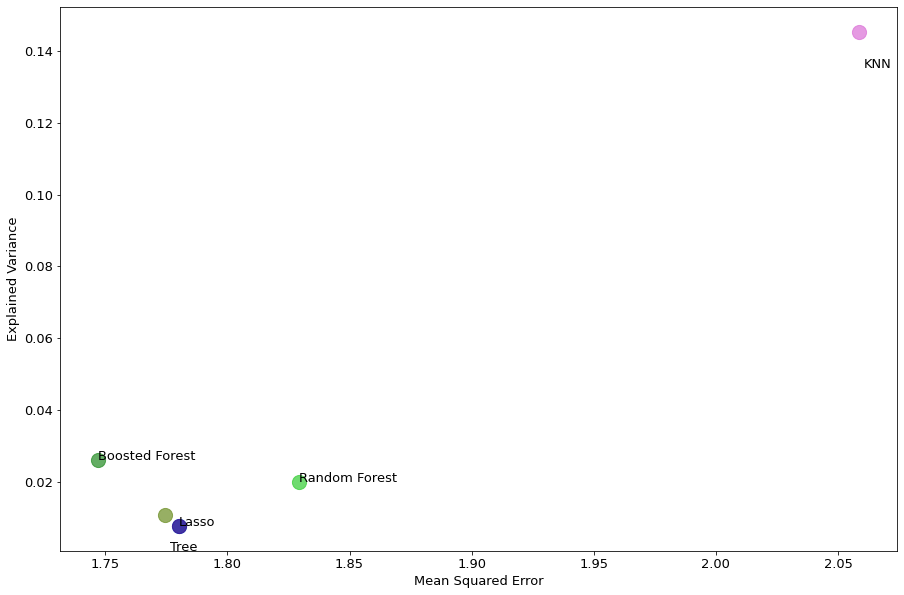

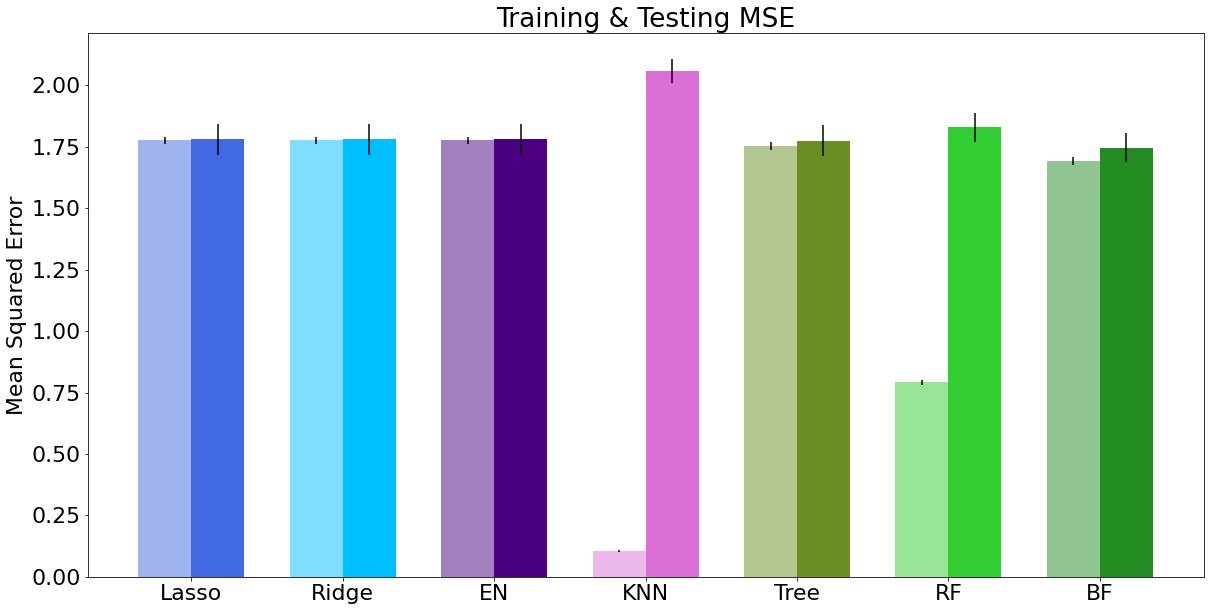

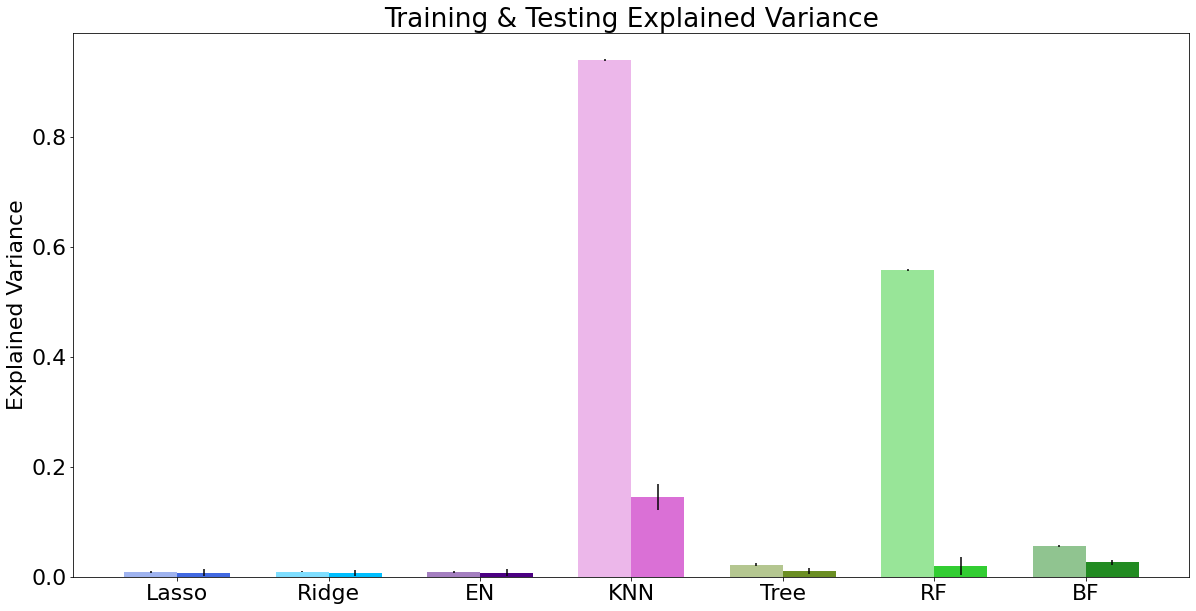

In [69]:
quant, qual = sepdata(X)
X = prep()

X = dropcolna(X)
X.info()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
models = main(X_train, y_train)

bias_var(models)
tt_mse(models)
tt_expvar(models)